In [316]:
import tweepy
from tweepy import OAuthHandler
from tqdm import tqdm
import numpy as np
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import re as re
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from textblob import TextBlob
from wordcloud import WordCloud
os.getcwd()
from twitter_creds import *
from sklearn.preprocessing import StandardScaler
##CONSUMER_KEY, CONSUMER_SECRET ,ACCESS_TOKEN ,ACCESS_TOKEN_SECRET

In [70]:
def OAuthVerifier():
    '''
    This method is used to authenticate the user and create an object of the API class
    '''
    authentication = tweepy.OAuthHandler(CONSUMER_KEY,CONSUMER_SECRET)
    authentication.set_access_token(ACCESS_TOKEN,ACCESS_TOKEN_SECRET)
    api = tweepy.API(authentication)
    
    return api

In [76]:
def getUserStatistics(user):
    '''
    This program is used to fetch the User information
    '''
    print('\nName : ', user.name)
    print('Screen Name : ', user.screen_name)
    print('ID : ', user.id)
    print('Account Creation Date and Time : ', user.created_at)
    print('Description : ', user.description)
    print('No. of followers : ', user.followers_count)
    print('No. of friends : ', user.friends_count)
    print('No. of favourite tweets  : ', user.favourites_count)
    print('No. of posted tweets : ', user.statuses_count)
    print('Associated URL : ', user.url)
api = OAuthVerifier()
user = api.me()
getUserStatistics(user)


Name :  Rahul Jain
Screen Name :  rahulxjain
ID :  81017168
Account Creation Date and Time :  2009-10-09 03:29:56
Description :  
No. of followers :  39
No. of friends :  73
No. of favourite tweets  :  2
No. of posted tweets :  15
Associated URL :  None


# Data Scraping through Twitter crawling service

In [77]:
username = 'elonmusk'
tweets = tweepy.Cursor(api.user_timeline, screen_name = username, tweet_mode='extended').items()

##creating a disctionary object having various fields 
tweet_dict = []

for t in tqdm(tweets):
    dic = {}
    dic['created_at'] = t.created_at
    dic['favorite_count'] = t.favorite_count
    dic['retweet_count'] = t.retweet_count
    dic['full_text'] = t.full_text
    dic['screen_name'] = t.user.screen_name
    tweet_dict.append(dic)

3230it [01:08, 47.23it/s]


#  Dict list --> pandas dataframe

In [79]:
elon_tweet = pd.DataFrame.from_dict(tweet_dict)
print(len(elon_tweet))
elon_tweet.info()

3230
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3230 entries, 0 to 3229
Data columns (total 5 columns):
created_at        3230 non-null datetime64[ns]
favorite_count    3230 non-null int64
full_text         3230 non-null object
retweet_count     3230 non-null int64
screen_name       3230 non-null object
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 126.2+ KB


In [81]:
elon_tweet.head()

,created_at,favorite_count,full_text,retweet_count,screen_name,created_year
0,2019-04-02 09:24:39,3697,@Tom_Heats Dogecoin might be my fav cryptocurr...,809,elonmusk,2019
1,2019-04-02 09:21:19,22313,Yup https://t.co/UpMKB24yNB,1288,elonmusk,2019
2,2019-04-02 08:50:44,759,@klod_ua @universal_sci Some challenges with i...,53,elonmusk,2019
3,2019-04-02 08:45:58,1641,@universal_sci What could possibly go wrong?,81,elonmusk,2019
4,2019-04-02 01:00:12,16452,@TrevMcKendrick No,558,elonmusk,2019


# Data wrangling - Transforming Features

Unique Years                :  [2019 2018]
Min & Max Created timestamp :  2018-02-21 13:06:19 2019-04-02 09:24:39
Unique Months               :  [ 4  3  2  1 12 11 10  9  8  7  6  5]
Unique days of week         :  [1 0 6 5 4 3 2]


Text(0,0.5,'Counts')

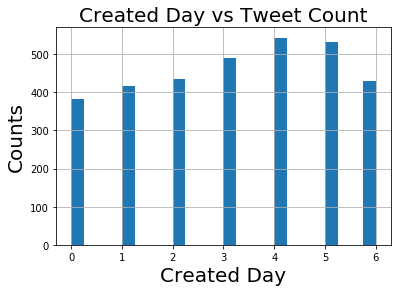

In [111]:
elon_tweet['created_year'] = elon_tweet['created_at'].dt.year
elon_tweet['created_month']=elon_tweet['created_at'].dt.month
elon_tweet['created_dayofweek']=elon_tweet['created_at'].dt.dayofweek
elon_tweet['created_day_name']=elon_tweet['created_at'].dt.weekday_name

print('Unique Years                : ',elon_tweet['created_year'].unique())
print('Min & Max Created timestamp : ',min(elon_tweet['created_at']),max(elon_tweet['created_at']))
print('Unique Months               : ',elon_tweet['created_month'].unique())
print('Unique days of week         : ',elon_tweet['created_dayofweek'].unique())

elon_tweet['created_dayofweek'].hist(bins=24)
plt.title('Created Day vs Tweet Count',{'fontsize' : 20})
plt.xlabel('Created Day',{'fontsize': 20})
plt.ylabel('Counts',{'fontsize': 20})

# **Insights
1. Looks like Elon Musk's frequency of tweeting increases as weekend approaches :)

2. He tweets maximum on Fridays and Saturdays .. for obvious reasons, off-office hours

3. Sunday he relaxes a bit :)

Text(0,0.5,'Counts')

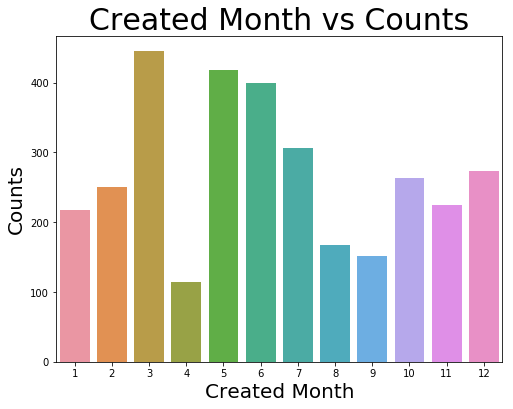

In [181]:
elon_tweet['created_date']=pd.to_datetime(elon_tweet['created_at'].dt.date)
ax = plt.figure(figsize=(8,6))
plot = sns.countplot(x=elon_tweet.created_month,data=elon_tweet)
plt.title('Created Month vs Counts',{'fontsize': 30})
plt.xlabel('Created Month',{'fontsize': 20})
plt.ylabel('Counts',{'fontsize': 20})

# **Insights 
Elon is most active during the months of Mar, May and June

Text(0,0.5,'Counts')

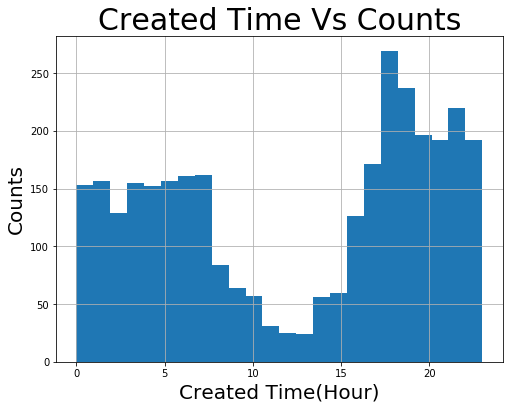

In [109]:
elon_tweet['created_time']=elon_tweet['created_at'].dt.hour
elon_tweet['created_time'].hist(bins=24,figsize=(8,6))
plt.title('Created Time Vs Counts',{'fontsize': 30})
plt.xlabel('Created Time(Hour)',{'fontsize': 20})
plt.ylabel('Counts',{'fontsize': 20})

# **Insights
1. The most number of tweets he makes are between 5 Pm and 8 PM, i.e. after leaving office and Supper

2. The least number of tweets comes between lunch hours which is expected

# Feature Engineering - Virality ( Measure of how viral is the tweet)

In [114]:

elon_tweet['virality'] = elon_tweet['favorite_count'] + 10 * elon_tweet['retweet_count'] 
elon_tweet.sort_values(by = 'virality',axis=0,ascending=False).head(10).full_text.to_frame()

,full_text
1400,Had to been done ur welcome https://t.co/7jT0f...
762,There are no coincidences https://t.co/9AEbbuXZGn
590,Host meme review? https://t.co/k2SFtIUh1k
1365,i🖤anime
256,"Yeah, I lift a little … https://t.co/UAJdv8qSw1"
2991,Oh btw I’m building a cyborg dragon
3148,"RT @NASA: Remembering Stephen Hawking, a renow..."
1184,"Rest in peace, Stan Lee. The many worlds of im..."
1350,How’d they know!? https://t.co/AZh4EOrgmc
487,😅 thank goodness it’s not November https://t.c...


# **Insights - Which tweets went viral ??
1. The ones which had some http:// links in it
2. He expressed his love to something, i guess that animation 
3. He mentioned his upcoming project
4. He vent out emotions 

# Data cleansing - Tweets
1. Bringing the text to lowercase
2. Removing new line character '\n'
3. Removing the http
4. Removing the special character like @
5. Removing stop words
6. Removing the words with length < 3
7. Removing the &amp text

In [116]:
####1. Bringing the text to lowercase
elon_tweet['clean_text'] = elon_tweet['full_text'].str.lower()
##2. Removing new line character '\n'
elon_tweet['clean_text'] = elon_tweet['clean_text'].str.replace('\n',' ')
##3. Removing the http 4. Removing the special character like @  
elon_tweet['clean_text'] = elon_tweet['clean_text'].apply(lambda x : ' '.join([word for word in x.split() if not re.search(r'((http)|@)+',word)]))
##5. Removing stop words
elon_tweet['clean_text'] = elon_tweet['clean_text'].apply(lambda x : ' '.join([word for word in x.split() if word not in stop_words]))
##6. Removing the words with length less than 3
elon_tweet['clean_text'] = elon_tweet['clean_text'].apply(lambda x : ' '.join([word for word in x.split() if len(word) > 2 ]))
##7. Removing the &amp text
elon_tweet['clean_text'] = elon_tweet['clean_text'].apply(lambda x : ' '.join([word for word in x.split() if not re.search(r'(;)+',word)]))
elon_tweet[['clean_text','created_date']].tail(10)

,clean_text,created_date
3220,successful deployment paz satellite low-earth ...,2018-02-22
3221,made back space fairing parafoil deployed. try...,2018-02-22
3222,going try catch giant fairing (nosecone) falco...,2018-02-22
3223,"love drones house, you’ll really love vast num...",2018-02-22
3224,"sure. let know, it’s still going. literally ze...",2018-02-22
3225,that’s random,2018-02-21
3226,"anyone curious, name inspired fault stars",2018-02-21
3227,openai supporters:,2018-02-21
3228,high altitude wind shear data shows probable l...,2018-02-21
3229,today’s falcon launch carries spacex test sate...,2018-02-21


# "Sentiment Analysis" - TextBlob - Finding the Polarity

In [117]:
elon_tweet['SA'] = elon_tweet['clean_text'].apply(lambda x : 1 if TextBlob(x).sentiment.polarity > 0 else -1 if TextBlob(x).sentiment.polarity < 0 else 0)
print('Unique Values of SA : ',elon_tweet['SA'].unique())
print(elon_tweet[['clean_text','SA']].groupby(by = 'SA').count())
elon_tweet[['clean_text','SA']].head()

Unique Values of SA :  [ 1  0 -1]
    clean_text
SA            
-1         411
 0        1368
 1        1451


,clean_text,SA
0,dogecoin might fav cryptocurrency. it’s pretty...,1
1,yup,0
2,challenges ice formation cryogenic propellant ...,0
3,could possibly wrong?,-1
4,,0


In [118]:
pos_tweet = elon_tweet.loc[elon_tweet.SA == 1]
neu_tweet = elon_tweet.loc[elon_tweet.SA == 0]
neg_tweet = elon_tweet.loc[elon_tweet.SA == -1]
print('Positive tweets % : {0:.2f}'.format(len(pos_tweet) * 100 /len(elon_tweet)))
print('Neutral tweets % : {0:.2f}%'.format(len(neu_tweet) * 100 /len(elon_tweet)))
print('Negative tweets % : {0:.2f}%'.format(len(neg_tweet) * 100 /len(elon_tweet)))

Positive tweets % : 44.92
Neutral tweets % : 42.35%
Negative tweets % : 12.72%


# Data Visualisation

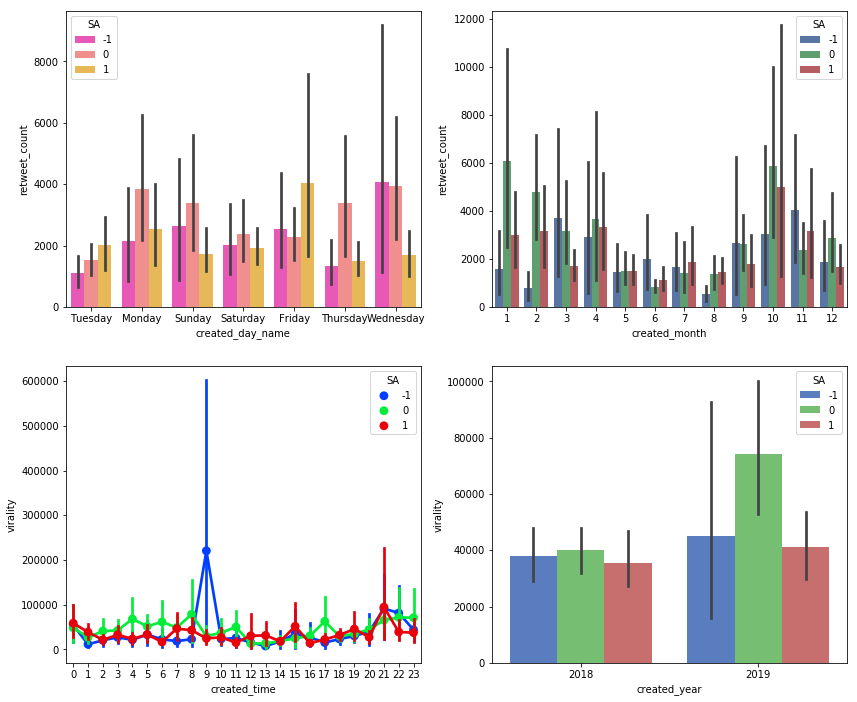

In [119]:
_,ax = plt.subplots(2,2,figsize=(14,12))
sns.barplot(x='created_day_name',y='retweet_count',hue='SA',data=elon_tweet,ax=ax[0,0],palette='spring')
sns.barplot(x='created_month',y='retweet_count',hue='SA',data=elon_tweet,ax=ax[0,1],palette='deep')
sns.pointplot(x='created_time',y='virality',hue='SA',data=elon_tweet,ax=ax[1,0],palette='bright')
sns.barplot(x='created_year',y='virality',hue='SA',data=elon_tweet,ax=ax[1,1],palette='muted')

# **Insights
1. Elon tweets maximum num of positive tweets on a friday, thats obvious , approaching weekend.
2. He tweets maximum negative comments on Wed. Thats middle of week. Understandable
3. The maximum retweet happened in the month of Jan and Oct. Well new year new strategies and Oct, about to close.
4. The most viral negative tweets happened at 9 AM.
5. The most viral positive tweets happened at 9 PM.
6. He tweeted more in 2019 than in 2018. This year he was more diplomatic in his comments and hence the highest percentage of his tweets were neutral in nature. :) Second highest being negative comments.

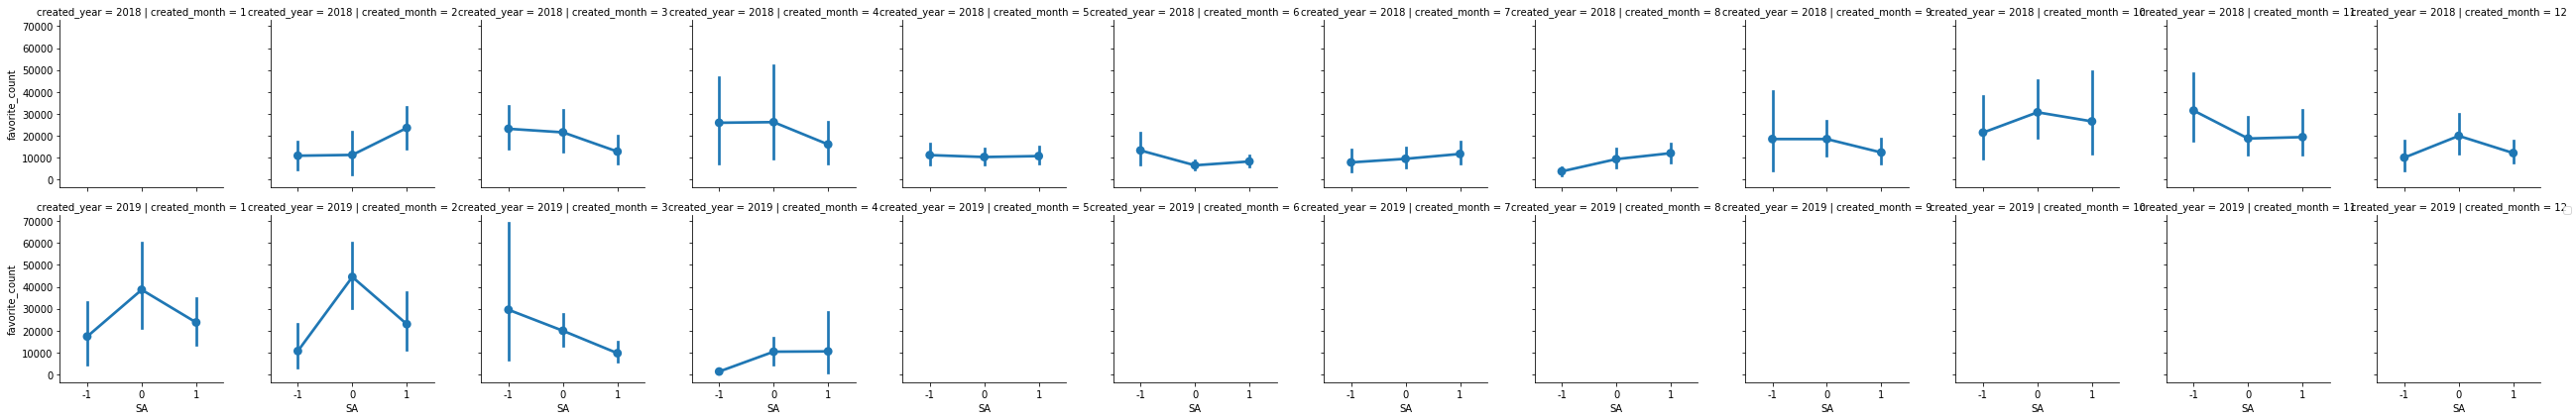

In [120]:
bar = sns.FacetGrid(elon_tweet,row='created_year',col = 'created_month')
bar.map(sns.pointplot,'SA','favorite_count')
bar.add_legend()

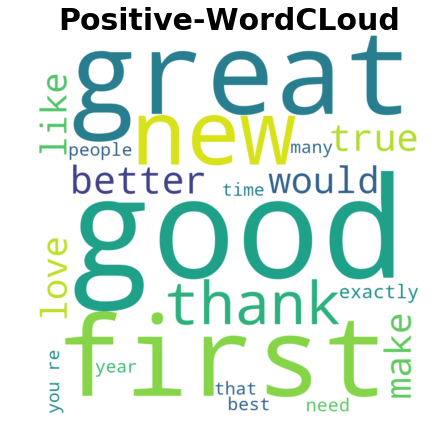

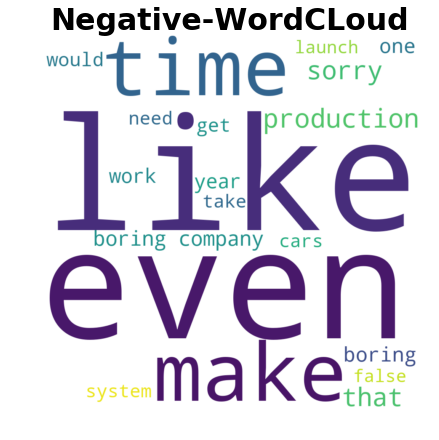

In [127]:
pos_text = ' '.join(tweet for tweet in pos_tweet['clean_text'])
neg_text = ' '.join(tweet for tweet in neg_tweet['clean_text'])

plt.figure(figsize = (7,7))
plt.subplot =(1, 1)
pos_wordcloud = WordCloud(width=1000, height=1000,background_color='white',
                          stopwords=['tesla','model','car','it']
                          ,max_words=20).generate(pos_text)
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Positive-WordCLoud',{'fontsize': 30,'fontweight' :'bold'})
plt.show()


plt.figure(figsize = (7,7))
plt.subplot =(1,2)
neg_wordcloud = WordCloud(width=1000, height=1000,background_color='white',max_words=20,
                          stopwords=['tesla','model','car','it']
                         ).generate(neg_text)
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Negative-WordCLoud',{'fontsize': 30,'fontweight' :'bold'})
plt.show()

# **Insights from Word cloud
--Positive Cloud--
1. He expresses his "love" towards things pretty often.
2. He is quite Generous as "Thank" is prominent.
3. He is quite upbeat about things, usage of words - Good, Better, Great

--Negative Cloud--
1. He is apologetic and asks for forgiveness quite often :)
2. He made quite a few negative comments about launch and Production.
3. He commented many times "Boring Company" which is quite a statement to make being a founder of the Company.

# "QUANDL" - API to get the Stock Price for US
https://www.quandl.com/data/EOD-End-of-Day-US-Stock-Prices

However Tesla Stock in particular was paid So i didnt Subscribe

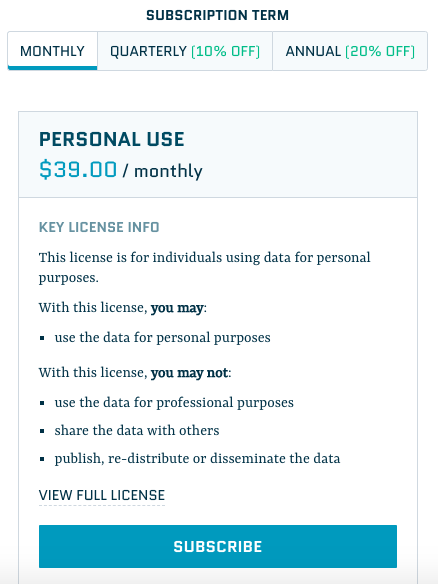

In [60]:
## Indicoio API Key ->  1afab6f1942c6a8050ea3156dc95eb79
##import indicoio
import quandl
quandl.ApiConfig.api_key = "gsJ2q_nsnj6NEzsn7VxH"
##tesla_stock_price = quandl.get("EOD/TSLA")
##ForbiddenError: (Status 403) (Quandl Error QEPx04) You do not have permission to view this dataset. 
##Please subscribe to this database to get access.
from IPython.display import Image
Image(filename="/Users/rahuljain/Desktop/sub.png",width=400,height=400)

# However I could get the JP Morgan Stock Price for FREE  :) 

In [61]:
jpmorgan_srock_price = quandl.get("EOD/JPM")
jpmorgan_srock_price.tail()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2019-03-26,99.82,100.4000,98.820,99.92,15985500.0,0.0,1.0,99.82,100.4000,98.820,99.92,15985500.0
2019-03-27,99.88,100.4499,99.080,99.58,12752866.0,0.0,1.0,99.88,100.4499,99.080,99.58,12752866.0
2019-03-28,100.00,100.8000,99.740,100.71,12450588.0,0.0,1.0,100.00,100.8000,99.740,100.71,12450588.0
2019-03-29,101.54,101.9900,100.585,101.23,14522008.0,0.0,1.0,101.54,101.9900,100.585,101.23,14522008.0
2019-04-01,102.15,104.6800,102.120,104.64,17499280.0,0.0,1.0,102.15,104.6800,102.120,104.64,17499280.0


# "Yahoo Finance" -Tesla Stock Price Obtained
https://in.finance.yahoo.com/quote/TSLA/history?period1=1519151400&period2=1554143400&interval=1d&filter=history&frequency=1d

In [168]:
os.getcwd()
os.listdir()
tsla_stock_price = pd.read_csv('TSLA_stock_price.csv')
print('Min & Max Date : ',min(tsla_stock_price['Date']),max(tsla_stock_price['Date']))
tsla_stock_price['created_date'] = pd.to_datetime(tsla_stock_price['Date'])
tsla_stock_price.head()

Min & Max Date :  2018-02-20 2019-04-01


,Date,Open,High,Low,Close,Adj Close,Volume,created_date
0,2018-02-20,334.470001,340.839996,331.500000,334.769989,334.769989,4009400,2018-02-20
1,2018-02-21,336.029999,339.690002,333.170013,333.299988,333.299988,3219600,2018-02-21
2,2018-02-22,335.529999,347.440002,334.750000,346.170013,346.170013,6969800,2018-02-22
3,2018-02-23,347.829987,354.989990,347.100006,352.049988,352.049988,5817400,2018-02-23
4,2018-02-26,353.500000,359.000000,352.359985,357.420013,357.420013,4340000,2018-02-26


# Merging two DataFrames ( Tweet & Stock Price)- elon_tweet_stock

In [318]:
elon_tweet_stock = pd.merge(elon_tweet,tsla_stock_price,how='left',left_on='created_date',right_on='created_date')
elon_tweet_stock_org = elon_tweet_stock.copy()

# Removing Weekend Data - As Stock Price Available for weekend

In [319]:
elon_tweet_stock.drop(elon_tweet_stock.loc[(elon_tweet_stock['created_day_name'].isin(['Saturday','Sunday'])) ]
                      .index,axis=0,inplace=True)
elon_tweet_stock.drop(elon_tweet_stock.loc[elon_tweet_stock.created_date == '2019-04-02']
                      .index,axis=0,inplace=True)
elon_tweet_stock.drop(elon_tweet_stock.loc[elon_tweet_stock.Low.isnull()].index,axis=0,inplace=True)
elon_tweet_stock = elon_tweet_stock.sort_values(by='created_date',ascending=True)

# Standardizing the Numeric Columns

In [320]:
##Numeric_columns = elon_tweet_stock.select_dtypes(include=[np.int64,np.float64]).columns.values
Numeric_columns = ['virality','Close','Volume']
scaler = StandardScaler()
scaler.fit(elon_tweet_stock[Numeric_columns])
elon_tweet_stock[Numeric_columns] = scaler.transform(elon_tweet_stock[Numeric_columns])
elon_tweet_stock['Year_Month'] = elon_tweet_stock['created_year'].astype(str) + elon_tweet_stock['created_month'].astype(str).str.pad(2,side='left',fillchar='0')

# Final Plots - Twitter v/s Business

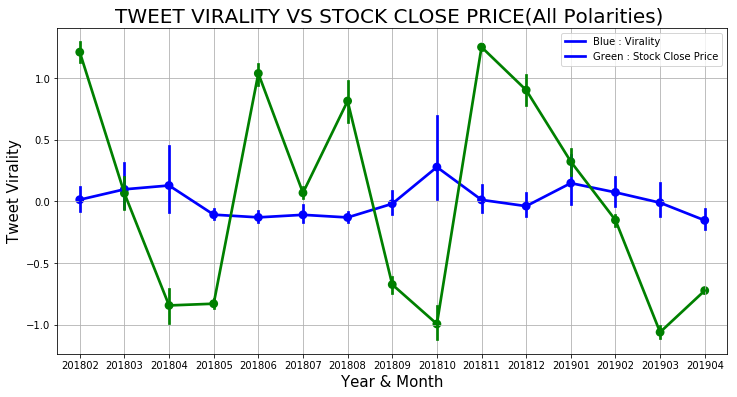

In [410]:
plt.figure(figsize=(12,6))
sns.pointplot(x='Year_Month',y='virality',data=elon_tweet_stock,color='Blue')
sns.pointplot(x='Year_Month',y='Close',data=elon_tweet_stock,color='Green')
plt.title('TWEET VIRALITY VS STOCK CLOSE PRICE(All Polarities) ',{'fontsize': 20})
plt.xlabel('Year & Month',{'fontsize': 15})
plt.ylabel('Tweet Virality',{'fontsize': 15})
plt.legend(['Blue : Virality ','Green : Stock Close Price'])
plt.grid(True)

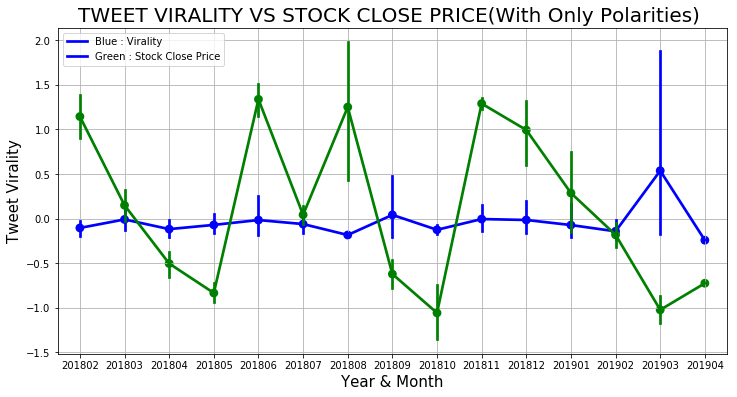

In [411]:
plt.figure(figsize=(12,6))
sns.pointplot(x='Year_Month',y='virality',data=elon_tweet_stock.loc[elon_tweet_stock.SA == -1],color='Blue')
sns.pointplot(x='Year_Month',y='Close',data=elon_tweet_stock.loc[elon_tweet_stock.SA == -1],color='Green')
plt.title('TWEET VIRALITY VS STOCK CLOSE PRICE(With Only Polarities) ',{'fontsize': 20})
plt.xlabel('Year & Month',{'fontsize': 15})
plt.ylabel('Tweet Virality',{'fontsize': 15})
plt.legend(['Blue : Virality ','Green : Stock Close Price'])
plt.grid(True)

# Conclusion
-There is a direct correlation between Elon Musk's tweet's virality and performance of Tesla stock.

-Tesla Stock will do well provided Elon musk keeps away from Twitter :) 